# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# magic word for producing visualizations in notebook
%matplotlib inline

# Import more Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
def preprocessing_data(df, features_to_drop, features_nan_negative_one, features_nan_nine, features_nan_ten):
    '''
    Function for preprocessing DataFrames for Arvato Project.
    Drops features to be dropped, overwrites "unknown"-values by NaN's and imputes by means.
    
    INPUT
    df: pandas DataFrame to perform cleaning steps on.
    features_to_drop (list): List of columns names to be dropped
    features_nan_negative_one (list): List of features where unknown values are represented as -1.
    features_nan_nine (list): List of features where unknown values are represented as 9.
    features_nan_ten (list): List of features where unknown values are represented as 10.
    features_nan_mean (list): List of features where NaN's are to be imputed as the mean of known values.
    
    OUTPUT
    df_clean: cleaned pandas DataFrame ready for modelling (no NaN's left)
    '''
    
    # Drop columns to drop
    try:
        df_clean = df.drop(columns = features_to_drop)
    except:
        None
    
    # Impute -1, 9, 10, then 0
    df_clean[features_nan_negative_one] = df_clean[features_nan_negative_one].replace(-1, np.NaN)
    df_clean[features_nan_nine] = df_clean[features_nan_nine].replace(9, np.NaN)
    df_clean[features_nan_ten] = df_clean[features_nan_ten].replace(10, np.NaN)
    
    features_nan_zero = list(set(df_clean.columns) \
                             - set(features_nan_negative_one) \
                             - set(features_nan_nine) \
                             - set(features_nan_ten)
                            )
    df_clean[features_nan_zero] = df_clean[features_nan_zero].replace(0, np.NaN)
    
    # Replace O, W by -1, 1 resp. in OST_WEST_KZ
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace(-1, np.NaN)
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace('W', 1)
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace('O', -1)
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].astype(float)
    
    # Handle 'X' values in CAMEO_DEUG_2015
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace('X', np.NaN)
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].astype(float)
    
    # Impute means
    imputer = SimpleImputer(strategy='mean')
    df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)
    
    return df_clean

In [3]:
def standardize_data(df, response = None):
    '''
    Function to standardize data and keep column names.
    Also don't standardize response column.
    
    INPUT:
    df: pandas DataFrame with numeric-only data to standardize.
    response: name (str) of response column to keep for supervised learning.
    
    OUTPUT:
    df_standardized
    '''
    scaler = StandardScaler()
    
    if response == None:
        df_standardized = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    else:
        df_standardized = pd.DataFrame(scaler.fit_transform(df.drop(columns = [response])), \
                                       columns = df.drop(columns = [response]).columns)
        df_standardized[response] = df[response]
        
    return df_standardized

In [4]:
def inertia_k_means(df, k_max):
    means = []
    inertias = []
    
    # Calculate KMeans and append number of clusters and corresponding inertia to lists
    for k in range(1, k_max):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
    
    # Draw elbow plot
    fig = plt.subplots(figsize = (10, 5))
    plt.plot(means, inertias, 'o-')
    plt.title('Inertia by number of clusters for general population')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

In [5]:
def learning_ROC_curves(classifier, X, y):
    '''
    Function to display precision-recall curves for trained classifiers on train dataset.
    INPUT:
    '''

    train_sizes, train_scores, valid_scores = learning_curve(classifier, X, y, \
                                                             train_sizes = np.linspace(0.01, 1, 20), \
                                                             scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    
    clf = classifier
    clf.fit(X, y)
    y_probas = cross_val_predict(clf, X, y, cv = 3, method = 'predict_proba')
    y_scores = y_probas[:, 1]
    
    fpr, tpr, thresholds_2 = roc_curve(y, y_scores)
    roc_auc = roc_auc_score(y, y_scores)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    print('Classifier: ' + re.findall(r'(^.*?)\(', str(classifier))[0])
    print('ROC AUC score train: ' + str(train_scores_mean[-1].round(2)))
    print('ROC AUC score validation: ' + str(valid_scores_mean[-1].round(2)))
    
    plt.suptitle('Learning and ROC curves of ' + re.findall(r'(^.*?)\(', str(classifier))[0])
    
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0.01, 1, 20)*100, train_scores_mean, 'b-', linewidth=2)
    plt.plot(np.linspace(0.01, 1, 20)*100, valid_scores_mean, 'r-', linewidth=2)
    plt.xlabel('% of training dataset')
    plt.ylabel('ROC AUC')
    plt.title('Learning curve')
    plt.xticks(np.arange(0., 100.05, 10))
    plt.yticks(np.arange(0.45, 1.02, 0.05))
    
    plt.subplot(2, 1, 2)
    plt.plot(fpr, tpr, label=f'ROC curve (ROC AUC = {roc_auc:0.2f})')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve validation')
    
    plt.show()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/3c/7t4ft8dd1zq15673ckx50whh0000gn/T/ipykernel_35365/2693282953.py:2: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/3c/7t4ft8dd1zq15673ckx50whh0000gn/T/ipykernel_35365/2693282953.py:3: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')


In [7]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### Drop all columns we have no further information on
There is a number of columns that we don't know how to interpret because in the Excelsheet ther ist no further information. Let's remove these features. Otherwise we could make imputing mistakes or run into difficulties interpreting our results.

In [8]:
columns_to_drop = list(set(azdias.columns) - \
                  set(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', \
                  'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'BIP_FLAG', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', \
                  'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT_RZ', \
                  'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', \
                  'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', \
                  'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', \
                  'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', \
                  'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', \
                  'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', \
                  'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', \
                  'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', \
                  'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE_RZ', \
                  'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', \
                  'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', \
                  'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST_RZ', \
                  'D19_VERSICHERUNGEN_RZ', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VOLLSORTIMENT_RZ', \
                  'D19_WEIN_FEINKOST_RZ', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', \
                  'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', \
                  'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GEOSCORE_KLS7', 'GREEN_AVANTGARDE', 'HAUSHALTSSTRUKTUR', \
                  'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', \
                  'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', \
                  'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', \
                  'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', \
                  'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', \
                  'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', \
                  'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', \
                  'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', \
                  'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10', \
                  'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', \
                  'KBA05_SEG9', 'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3', \
                  'KBA05_ZUL4', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', \
                  'KBA13_ALTERHALTER_61', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI', 'KBA13_AUTOQUOTE', 'KBA13_BJ_1999', \
                  'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW', \
                  'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400', 'KBA13_CCM_0_1400', 'KBA13_CCM_1500', \
                  'KBA13_CCM_1401_2500', 'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', \
                  'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN', 'KBA13_FAB_SONSTIGE', \
                  'KBA13_FIAT', 'KBA13_FORD', 'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30', \
                  'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_50', \
                  'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65', 'KBA13_HALTER_66', \
                  'KBA13_HERST_ASIEN', 'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', \
                  'KBA13_HERST_FORD_OPEL', 'KBA13_HERST_SONST', 'KBA13_KMH_110', 'KBA13_KMH_140', \
                  'KBA13_KMH_180', 'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211', 'KBA13_KMH_250', \
                  'KBA13_KMH_251', 'KBA13_KRSAQUOT', 'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ', \
                  'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN', 'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', \
                  'KBA13_KRSZUL_NEU', 'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', \
                  'KBA13_KW_0_60', 'KBA13_KW_70', 'KBA13_KW_61_120', 'KBA13_KW_80', 'KBA13_KW_90', 'KBA13_KW_110', \
                  'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN', \
                  'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT', 'KBA13_SEG_GELAENDEWAGEN', \
                  'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN', \
                  'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN', \
                  'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_OBERKLASSE', \
                  'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', \
                  'KBA13_SEG_WOHNMOBILE', 'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA', \
                  'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2', 'KBA13_VORB_3', 'KBA13_VW', \
                  'KKK', 'KONSUMNAEHE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', \
                  'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR', 'MOBI_REGIO', \
                  'NATIONALITAET_KZ', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'OST_WEST_KZ', 'PLZ8_ANTG1', \
                  'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', \
                  'PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 'RELAT_AB', 'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL', \
                  'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_MAT', \
                  'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', \
                  'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP', 'WOHNDAUER_2008', 'WOHNLAGE', \
                  'WACHSTUMSGEBIET_NB', 'W_KEIT_KIND_HH', 'ZABEOTYP']))

### Look for columns with most NaN-Values

In [9]:
azdias.isnull().mean().sort_values(ascending = False).head(20)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_SOZIALES                   0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
KBA05_ALTER4                   0.149597
KBA05_ANHANG                   0.149597
KBA05_KRSAQUOT                 0.149597
KBA05_HERST5                   0.149597
dtype: float64

In [10]:
customers.isnull().mean().sort_values(ascending = False).head(20)

ALTER_KIND4        0.998769
ALTER_KIND3        0.993347
ALTER_KIND2        0.973389
ALTER_KIND1        0.938607
KK_KUNDENTYP       0.584064
EXTSEL992          0.444989
KBA05_KRSKLEIN     0.292092
KBA05_KRSHERST1    0.292092
KBA05_GBZ          0.292092
KBA05_HERST1       0.292092
KBA05_HERST2       0.292092
KBA05_HERST3       0.292092
KBA05_HERST4       0.292092
KBA05_HERST5       0.292092
KBA05_KRSAQUOT     0.292092
KBA05_KRSVAN       0.292092
KBA05_KRSHERST3    0.292092
KBA05_KRSOBER      0.292092
KBA05_DIESEL       0.292092
KBA05_KRSZUL       0.292092
dtype: float64

The "ALTER_KINDX" columns have a lot of NaN's in both the general population and costumers set. As these columns do not seem to yield a lot of useful information. Let's drop the "ALTER_KINDX" columns, as they are mostly NaN's. Why not impute? It seems there are too little notnull values for useful imputation. And since these are quantative variables, there is no sensible way of imputing an "unknown" value.

In [11]:
azdias.select_dtypes(include = object).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


Also let's drop the non-numeric columns D19_LETZTER_KAUF_BRANCHE and EINGEFUEGT_AM, since they don't seem too important.

In [12]:
# begin list with columns to drop
columns_to_drop = columns_to_drop + ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'Unnamed: 0', 'LNR']

Let's further investigate the columns KK_KUNDENTYP and EXTSEL992.

In [13]:
'KK_KUNDENTYP' in columns_to_drop

True

In [14]:
'EXTSEL992' in columns_to_drop

True

We are dropping these columns anyway so we don't have to further investigate how to impute NaN's.

### Make out and collect more features to drop
There are two types of census data referring to car propriety in neighbourhoods (microcell RR3_ID and PLZ8 respectively). The names of one type of columns start with 'KBA05' while the others start with 'KBA13'. These information seem quite redundant as both types of counting cars of different fabrics yield basically the same information. Thus we can reduce complexity and required calculation power significantly by dropping one of these types. I decide to drop all columns that contain the substring 'KBA05' as these seem less specific.

In [15]:
columns_to_drop = columns_to_drop + list(azdias.loc[:, azdias.columns.str.contains('KBA05')].columns)

In [16]:
# Check CAMEO columns for usability
azdias.loc[:, azdias.columns.str.contains('CAMEO')].head(20)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN
1,8A,8.0,51.0
2,4C,4.0,24.0
3,2A,2.0,12.0
4,6B,6.0,43.0
5,8C,8.0,54.0
6,4A,4.0,22.0
7,2D,2.0,14.0
8,1A,1.0,13.0
9,1E,1.0,15.0


These CAMEO_DEU_2015-column contains qualitative data encoded in some ordinal code. To make sense for ML modelling techniques out of the information, i would have to transform this into dummy variables. However, some of the information is stored in the CAMEO_DEUG_2015-columns, which is infact ordinal data. CAMEO_INTL_2015 is semi-ordinal data (households from wealthy to poor but in different life stages) encoded ordinally.
For clarity reasons in transporting the information i will only keep CAMEO_DEUG_2015-column and make it an INT-column.

In [17]:
columns_to_drop = columns_to_drop + ['CAMEO_DEU_2015', 'CAMEO_INTL_2015']

### Collect Features with shared "Unknown"-code for imputation
Because some features in the datasets encode "Unknown" as 0 and others as -1 or 9 or 10, i want to collect features of these categories in different lists for imputation.
As most features represent "Unknown" as 0, i will only collect the other ones and handle all remaining features as features with "unknown" encoded as 0. 
Since almost all features ar ordinal, i don't want unknowns to be imputed by e.g. -1 but rather by the mean. Thus i will first change the "unknown" encoded values to NaN's and then impute by means.

In [18]:
azdias['OST_WEST_KZ']

0         NaN
1           W
2           W
3           W
4           W
         ... 
891216      W
891217      W
891218      W
891219      W
891220      W
Name: OST_WEST_KZ, Length: 891221, dtype: object

In [19]:
features_unknown_negative_one = list(set(['AGER_TYP', 'ALTER_HH', 'BALLRAUM', \
                                'CAMEO_DEUG_2015', 'KK_KUNDENTYP', 'EWDICHTE', 'FINANZTYP', \
                                'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', \
                                'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'HEALTH_TYP', 'INNENSTADT', \
                                'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60', \
                                'KBA13_ALTERHALTER_61', 'KBA13_AUDI', 'KBA13_AUTOQUOTE', 'KBA13_BJ_1999', \
                                'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', \
                                'KBA13_BJ_2009', 'KBA13_BMW', 'KBA13_CCM_1000', 'KBA13_CCM_1200', \
                                'KBA13_CCM_1400', 'KBA13_CCM_0_1400', 'KBA13_CCM_1500', 'KBA13_CCM_1401_2500', \
                                'KBA13_CCM_1600', 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', \
                                'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN', \
                                'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD', 'KBA13_HALTER_20', \
                                'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', \
                                'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', \
                                'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN', 'KBA13_HERST_AUDI_VW', \
                                'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', \
                                'KBA13_HERST_SONST', 'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_180', \
                                'KBA13_KMH_0_140', 'KBA13_KMH_140_210', 'KBA13_KMH_211', 'KBA13_KMH_250', \
                                'KBA13_KMH_251', 'KBA13_KRSAQUOT', 'KBA13_KRSHERST_AUDI_VW', \
                                'KBA13_KRSHERST_BMW_BENZ', 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN', \
                                'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU', 'KBA13_KW_30', \
                                'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_0_60', \
                                'KBA13_KW_70', 'KBA13_KW_61_120', 'KBA13_KW_80', 'KBA13_KW_90', \
                                'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_MAZDA', 'KBA13_MERCEDES', \
                                'KBA13_MOTOR', 'KBA13_NISSAN', 'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT', \
                                'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_KLEINST', \
                                'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS', \
                                'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_OBEREMITTELKLASSE', \
                                'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN', \
                                'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE', 'KBA13_SITZE_4', \
                                'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA', 'KBA13_VORB_0', 'KBA13_VORB_1', \
                                'KBA13_VORB_1_2', 'KBA13_VORB_2', 'KBA13_VORB_3', 'KBA13_VW', 'KK_KUNDENTYP', 'ORTSGR_KLS9', \
                                'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_GBZ', \
                                'PLZ8_HHZ', 'RELAT_AB', 'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL', \
                                'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', \
                                'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ', \
                                'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP', \
                                'WOHNLAGE', 'ZABEOTYP'
                               ]) - set(columns_to_drop))

In [20]:
features_unknown_nine = list(set(['D19_KONSUMTYP' 
                        ])-set(columns_to_drop))

In [21]:
features_unknown_ten = list(set(['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', \
                        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                        'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', \
                        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'
                       ]) - set(columns_to_drop))

In [22]:
azdias_clean = preprocessing_data(azdias, \
                        columns_to_drop, \
                        features_unknown_negative_one, \
                        features_unknown_nine, \
                        features_unknown_ten)

In [23]:
azdias_clean.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.675376,10.864126,8.354924,1.346823,1.802824,1.070126,4.153043,5.537665,2.0,1.832804,...,1.0,1.590134,1.318519,1.511166,4.147141,7.908791,4.052836,3.0,1.0,2.0
1,1.675376,0.000000,11.000000,1.346823,2.000000,1.070126,6.000000,8.000000,5.0,1.832804,...,1.0,3.000000,1.318519,2.000000,3.000000,9.000000,4.000000,5.0,2.0,1.0
2,1.675376,17.000000,10.000000,1.346823,1.000000,1.070126,2.000000,4.000000,3.0,1.832804,...,4.0,2.000000,1.318519,1.000000,3.000000,9.000000,2.000000,5.0,2.0,3.0
3,2.000000,13.000000,1.000000,1.346823,1.802824,1.070126,4.000000,2.000000,2.0,1.832804,...,4.0,1.000000,1.318519,1.000000,4.147141,9.000000,7.000000,3.0,2.0,4.0
4,1.675376,20.000000,3.000000,1.346823,4.000000,1.070126,2.000000,6.000000,5.0,3.000000,...,7.0,2.000000,1.318519,2.000000,2.000000,9.000000,3.000000,4.0,1.0,3.0


In [24]:
# Check if there are any NaN's left
azdias_clean.isnull().sum().sum()

0

In [25]:
# Check if there are any nun numerical columns left
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 207 entries, AGER_TYP to ALTERSKATEGORIE_GROB
dtypes: float64(207)
memory usage: 1.4 GB


In [26]:
# Drop extra columns from customers df for preprocessing to work. We will not use those columns anyway
customers.drop(columns = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace = True)

In [27]:
customers_clean = preprocessing_data(customers, \
                        columns_to_drop, \
                        features_unknown_negative_one, \
                        features_unknown_nine, \
                        features_unknown_ten)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [28]:
azdias_clean.shape

(891221, 207)

In [29]:
customers_clean.shape

(191652, 207)

### KMeans Clustering
For an unsupervised learning technique i choose KMeans Clustering, as we have a lot of features and clustering helps reducing this complexity and find common features.

#### Standardize cleaned datasets

In [30]:
# Fit scaler to the general population dataset 
# as well as customers dataset for later user
azdias_trans = standardize_data(azdias_clean)
customers_trans = standardize_data(customers_clean)

In [31]:
# Check if transformed data seems plausible
azdias_trans.head(5)

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-6.108901e-16,-7.282261e-16,1.202528e-16,5.162251e-15,-2.110766e-16,-2.654898e-14,-8.599399e-16,-7.568797e-16,-1.026509,0.000000,...,-1.455284,-1.385317e-15,4.513589e-15,-4.748069e-16,0.000000,-4.821477e-16,-9.628753e-16,-0.267936,-1.045218,-0.727373
1,-6.108901e-16,-1.484600e+00,1.790619e-01,5.162251e-15,1.874365e-01,-2.654898e-14,8.941175e-01,1.049165e+00,0.859488,0.000000,...,-1.455284,1.466005e+00,4.513589e-15,1.045294e+00,-0.704046,5.923631e-01,-2.863979e-02,1.210585,0.956738,-1.663024
2,-6.108901e-16,8.384771e-01,1.113656e-01,5.162251e-15,-7.631679e-01,-2.654898e-14,-1.042295e+00,-6.551765e-01,-0.397844,0.000000,...,-0.011411,4.261867e-01,4.513589e-15,-1.093046e+00,-0.704046,5.923631e-01,-1.112741e+00,1.210585,0.956738,0.208278
3,8.931071e-01,2.918706e-01,-4.979011e-01,5.162251e-15,-2.110766e-16,-2.654898e-14,-7.408866e-02,-1.507347e+00,-1.026509,0.000000,...,-0.011411,-6.136320e-01,4.513589e-15,-1.093046e+00,0.000000,5.923631e-01,1.597512e+00,-0.267936,0.956738,1.143930
4,-6.108901e-16,1.248432e+00,-3.625085e-01,5.162251e-15,2.088645e+00,-2.654898e-14,-1.042295e+00,1.969943e-01,0.859488,4.179478,...,1.432462,4.261867e-01,4.513589e-15,1.045294e+00,-1.317786,5.923631e-01,-5.706904e-01,0.471325,-1.045218,0.208278


#### Find reasonable number of clusters using an elbow plot

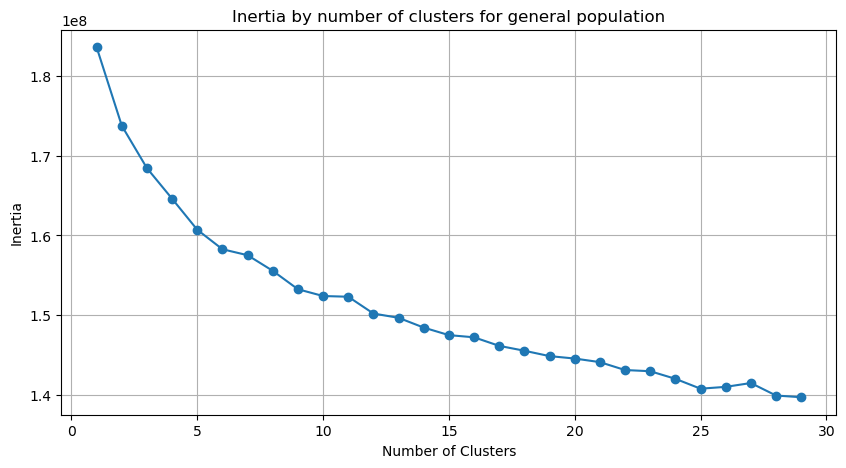

In [32]:
inertia_k_means(azdias_trans, 30)

I decide for using 12 clusters, as only after this point, inertie decrease seems to drop low consistently.

### Application of KMeans Clustering to general population and customers datasets

In [49]:
kmeans = KMeans(n_clusters = 12, random_state = 42)

In [50]:
kmeans.fit(azdias_trans)

KMeans(n_clusters=12, random_state=42)

In [51]:
if 'cluster' in azdias_clean.columns:
    azdias_trans.drop(columns = ['cluster'], inplace = True)
    customers_trans.drop(columns = ['cluster'], inplace = True)
azdias_trans['cluster'] = kmeans.predict(azdias_trans) + 1
customers_trans['cluster'] = kmeans.predict(customers_trans) + 1

# Note: Increase cluster number by 1 so that we get clusters from 1-4 and not from 0-3

As the model was fit on azdias_trans, i now want to see if any of the clusters make a difference between the two groups, before we can investigate on these cluster to further identify single features of difference.

We will therefore compare the shares of clusters in both groups. Why do counts not suffice? Because there are a lot more total datapoints in the population dataset than in the customers dataset. An easy comparison is only granted by comparing shares.

In [52]:
azdias_trans['cluster'].value_counts().sort_index()

1     158636
2      76570
3      66905
4      62025
5      64191
6      87953
7      53547
8      58540
9     105484
10     32091
11     57866
12     67413
Name: cluster, dtype: int64

In [53]:
customers_trans['cluster'].value_counts().sort_index()

1     50156
2      9729
3     19849
4     14845
5      5406
6     19856
7      4363
8     12040
9     24832
10     7829
11     5413
12    17334
Name: cluster, dtype: int64

On first glance we can already see that there are some huge differences.

In [54]:
# First save cluster sizes
population_cluster_sizes = azdias_trans['cluster'].value_counts().sort_index()
customers_cluster_sizes = customers_trans['cluster'].value_counts().sort_index()

In [55]:
# Create DataFrame with counts of both groups and shares of both groups
clusters_data = pd.concat([population_cluster_sizes, customers_cluster_sizes], 
                            axis = 1).reset_index()
clusters_data.columns = ['cluster', 'population_count', 'customers_count']

# Calculate shares
clusters_data['population_share'] = clusters_data['population_count']/clusters_data['population_count'].sum()
clusters_data['customers_share'] = clusters_data['customers_count']/clusters_data['customers_count'].sum()

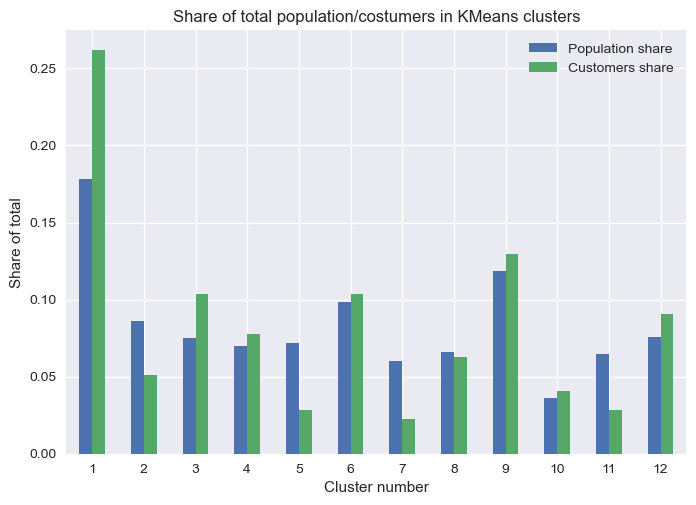

In [56]:
# Plot shares
plt.style.use('seaborn-v0_8')

clusters_data.plot(x = 'cluster', y = ['population_share', 'customers_share'], kind = 'bar')
plt.xlabel('Cluster number')
plt.ylabel('Share of total')
plt.title('Share of total population/costumers in KMeans clusters')
plt.legend(['Population share', 'Customers share'])
plt.xticks(rotation = 0)
plt.savefig('cluster_shares.png', dpi=500);

print()

We can see that we can call clusters 2, 5, 7, and 11 "population clusters" and that clusters 1 and 3 are rather "customers clusters".

For further analysis of the features that make a difference, we will look at the features with the highest differences in clusters 2, 5, 7, and 11 in comparison to clusters 1 and 3.

In [57]:
population_cluster_azdias = azdias_trans[azdias_trans['cluster'].isin([2, 5, 7, 11])].drop(columns = ['cluster']).mean()
customers_cluster_azdias = azdias_trans[azdias_trans['cluster'].isin([1, 3])].drop(columns = ['cluster']).mean()

In [58]:
differences_clusters = population_cluster_azdias - customers_cluster_azdias

In [59]:
# Features that are not likely to have high values for customers
differences_clusters[differences_clusters > 0.5].sort_values(ascending = False)

SEMIO_SOZ                  1.095698
SEMIO_VERT                 1.080268
KBA13_HALTER_30            1.001421
KBA13_ALTERHALTER_30       0.973158
PLZ8_BAUMAX                0.894827
HH_EINKOMMEN_SCORE         0.875599
KBA13_FAB_SONSTIGE         0.858705
KBA13_HERST_SONST          0.858705
PLZ8_ANTG3                 0.858270
PLZ8_ANTG4                 0.829287
KBA13_HALTER_35            0.725011
KBA13_HALTER_25            0.721462
SEMIO_KULT                 0.700336
KBA13_HERST_ASIEN          0.649811
KBA13_SEG_KOMPAKTKLASSE    0.614643
CAMEO_DEUG_2015            0.599227
KBA13_SITZE_5              0.589144
KBA13_RENAULT              0.588119
ORTSGR_KLS9                0.582853
EWDICHTE                   0.553948
KBA13_FAB_ASIEN            0.540641
KBA13_NISSAN               0.520821
dtype: float64

In [60]:
# More Features that are not likely to have high values for customers
differences_clusters[(differences_clusters > 0.5) & ~differences_clusters.index.str.contains('KBA13')].sort_values(ascending = False)

SEMIO_SOZ             1.095698
SEMIO_VERT            1.080268
PLZ8_BAUMAX           0.894827
HH_EINKOMMEN_SCORE    0.875599
PLZ8_ANTG3            0.858270
PLZ8_ANTG4            0.829287
SEMIO_KULT            0.700336
CAMEO_DEUG_2015       0.599227
ORTSGR_KLS9           0.582853
EWDICHTE              0.553948
dtype: float64

In [61]:
# Features that are likely to have high values for customers
differences_clusters[differences_clusters < -0.6].sort_values(ascending = True)

OST_WEST_KZ               -1.155072
SEMIO_KRIT                -0.934857
PLZ8_ANTG1                -0.894258
KBA13_AUTOQUOTE           -0.888030
KBA13_SITZE_6             -0.887393
SEMIO_DOM                 -0.857838
SEMIO_KAEM                -0.795706
KBA13_SEG_GROSSRAUMVANS   -0.789820
FINANZ_UNAUFFAELLIGER     -0.743620
PLZ8_GBZ                  -0.673854
KBA13_SEG_VAN             -0.668861
KBA13_HALTER_55           -0.659182
KBA13_SEG_GELAENDEWAGEN   -0.634162
ANREDE_KZ                 -0.620271
MOBI_REGIO                -0.619488
KBA13_ALTERHALTER_60      -0.618388
KBA13_KRSAQUOT            -0.605435
dtype: float64

In [62]:
# More Features that are  likely to have high values for customers
differences_clusters[(differences_clusters < -0.5) & ~differences_clusters.index.str.contains('KBA13')].sort_values(ascending = True)

OST_WEST_KZ             -1.155072
SEMIO_KRIT              -0.934857
PLZ8_ANTG1              -0.894258
SEMIO_DOM               -0.857838
SEMIO_KAEM              -0.795706
FINANZ_UNAUFFAELLIGER   -0.743620
PLZ8_GBZ                -0.673854
ANREDE_KZ               -0.620271
MOBI_REGIO              -0.619488
INNENSTADT              -0.583077
FINANZ_ANLEGER          -0.552366
KONSUMNAEHE             -0.506742
dtype: float64

#### Conclusion of Analysis
To conclude our analysis i will try and summarize the findings with an bit of interpretation.

Features that typically do _not_ fit customers of the organic mail-order company.
- Neighbourhoods with a lot of small cars or those of typical small car brands (Renault or Asian cars)
- Less social minded
- Lower household income
- Being rather young (more clearly: customers on are average somewhat older than non-customers)
- Higher density of inhabitants in neighbourhood

Features that typically _do_ fit customers of the organic mail-order company.
- Living in Western Germany (former FGR)
- Neighbourhoods with a lot of big cars or expensive car brands (VAN, Mercedes, Audi, BMW)
- Lower affinity to be critical minded
- Being rather old (more clearly: customers on average are somewhat older than non-customers)
- Larger Distance to city centers

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [63]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/var/folders/3c/7t4ft8dd1zq15673ckx50whh0000gn/T/ipykernel_35365/3492614913.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


### 1. Clean and standardize training data, create train-test-split from training data

This time it would make sense, not to delete as many columns, as we don't need to interpret single columns. There might be useful information for an ML model in some columns we deletet earlier.
##### I actually tried both, deleting and not deleting all the columns and not deleting worked better in terms of ROC AUC score.

In [64]:
# Identify further columns with more than 20% NaN's and assign them as
columns_to_drop_new = list(mailout_train.isnull().mean()[mailout_train.isnull().mean()>0.3].index)

# Find columns with dtype object
columns_object = list(mailout_train.drop(columns = columns_to_drop_new).select_dtypes(include=[object]).columns)

columns_to_drop_new = columns_to_drop_new + [column for column in columns_object if not column in ['OST_WEST_KZ', 'CAMEO_DEUG_2015']]

In [65]:
mailout_train_clean = preprocessing_data(
                        mailout_train.drop(columns = 'RESPONSE'), \
                        columns_to_drop_new, \
                        features_unknown_negative_one, \
                        features_unknown_nine, \
                        features_unknown_ten)
mailout_train_trans = standardize_data(mailout_train_clean)

In [66]:
X = mailout_train_trans
y = mailout_train['RESPONSE']

### 2. Fit, evaluate and compare different classifiers
I want to compare three Classifiers: RandomForestClassifier, AdaBoostClassifier, GradientBoostinRegressor. I want to check how the models perform on the training data and how they perform on cross validation regarding ROC AUC score - since this was the question of the past kaggle competition. Also i found  useful guidance on ROC AUC in my book on machine learning. 

### RandomForestClassifier

In [67]:
# Train classifier
forest_clf = RandomForestClassifier(n_estimators = 500)
forest_clf.fit(X, y)
forest_pred = forest_clf.predict(X)

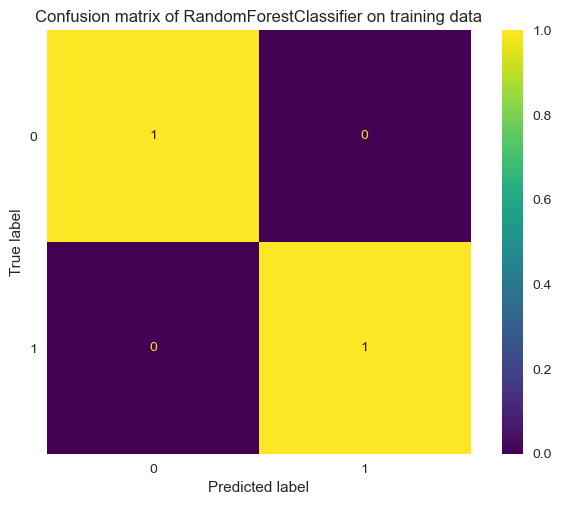

In [68]:
# Display confusion matrix
conmat_forest = confusion_matrix(y, forest_pred, normalize = 'true', labels=forest_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = conmat_forest, display_labels=forest_clf.classes_)
disp.plot()
plt.title('Confusion matrix of RandomForestClassifier on training data')
plt.grid(False)

Classifier: RandomForestClassifier
ROC AUC score train: 1.0
ROC AUC score validation: 0.64


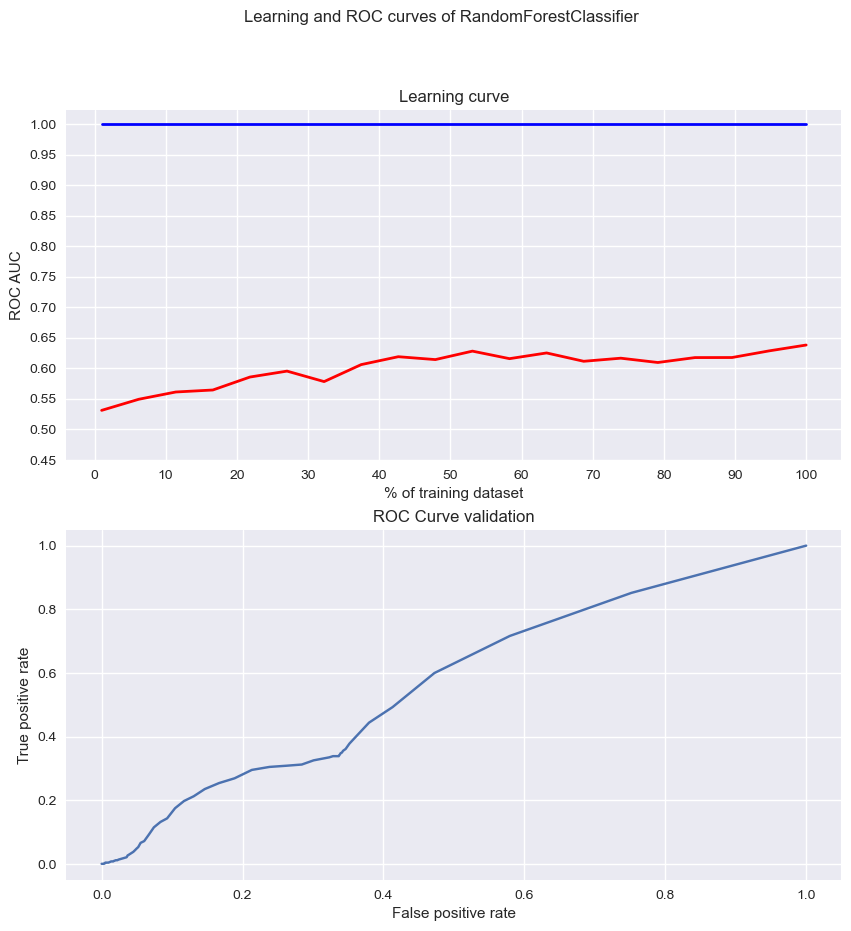

In [69]:
learning_ROC_curves(RandomForestClassifier(), X, y)

### AdaBoostClassifier

In [70]:
ada_clf = AdaBoostClassifier(
    algorithm = 'SAMME'
)
ada_clf.fit(X, y)
ada_pred = ada_clf.predict(X)

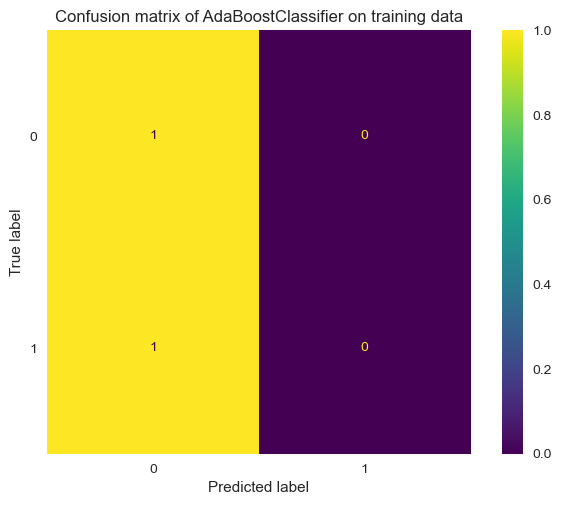

In [71]:
# Display confusion matrix
conmat_ada = confusion_matrix(y, ada_pred, normalize = 'true', labels=ada_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = conmat_ada, display_labels=ada_clf.classes_)
disp.plot()
plt.title('Confusion matrix of AdaBoostClassifier on training data')
plt.grid(False)

Classifier: AdaBoostClassifier
ROC AUC score train: 0.81
ROC AUC score validation: 0.76


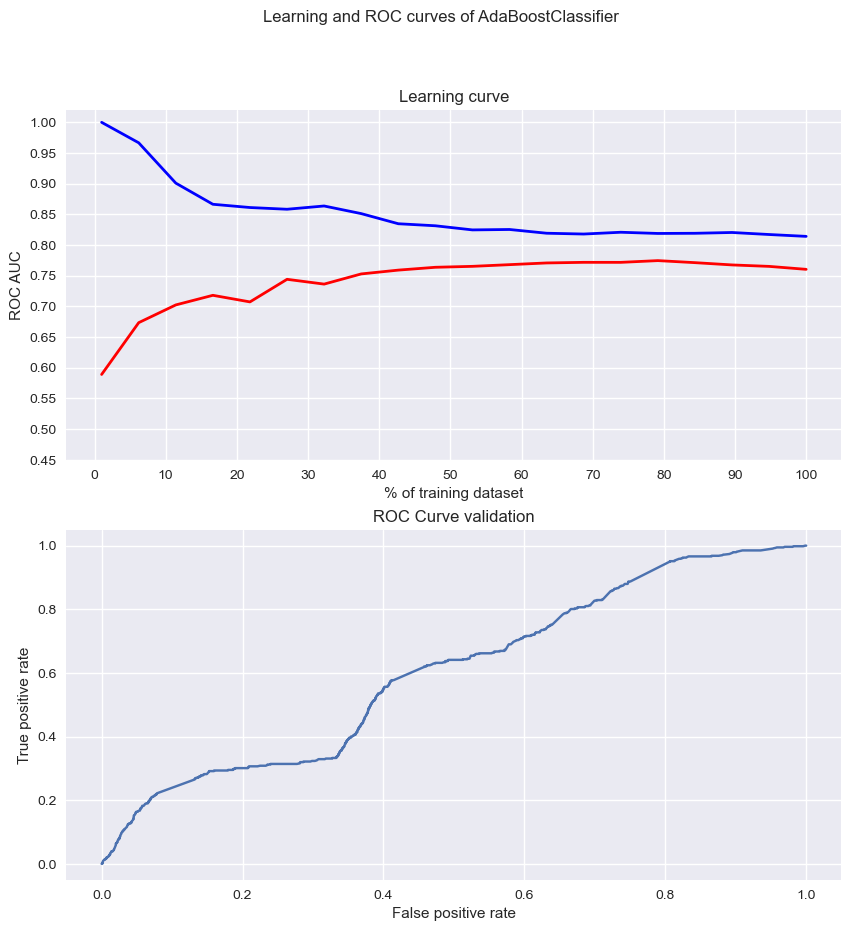

In [72]:
learning_ROC_curves(AdaBoostClassifier(algorithm = 'SAMME'), X, y)

### GradientBoostingClassifier

In [73]:
gbrt_clf = GradientBoostingClassifier()
gbrt_clf.fit(X, y)
gbrt_pred = gbrt_clf.predict(X)

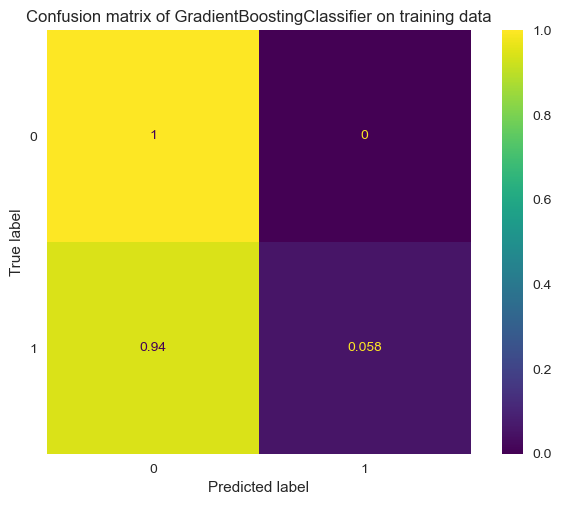

In [74]:
# Display confusion matrix
conmat_gbct = confusion_matrix(y, gbrt_pred, normalize = 'true', labels=gbrt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = conmat_gbct, display_labels=gbrt_clf.classes_)
disp.plot()
plt.title('Confusion matrix of GradientBoostingClassifier on training data')
plt.grid(False)

Classifier: GradientBoostingClassifier
ROC AUC score train: 0.85
ROC AUC score validation: 0.77


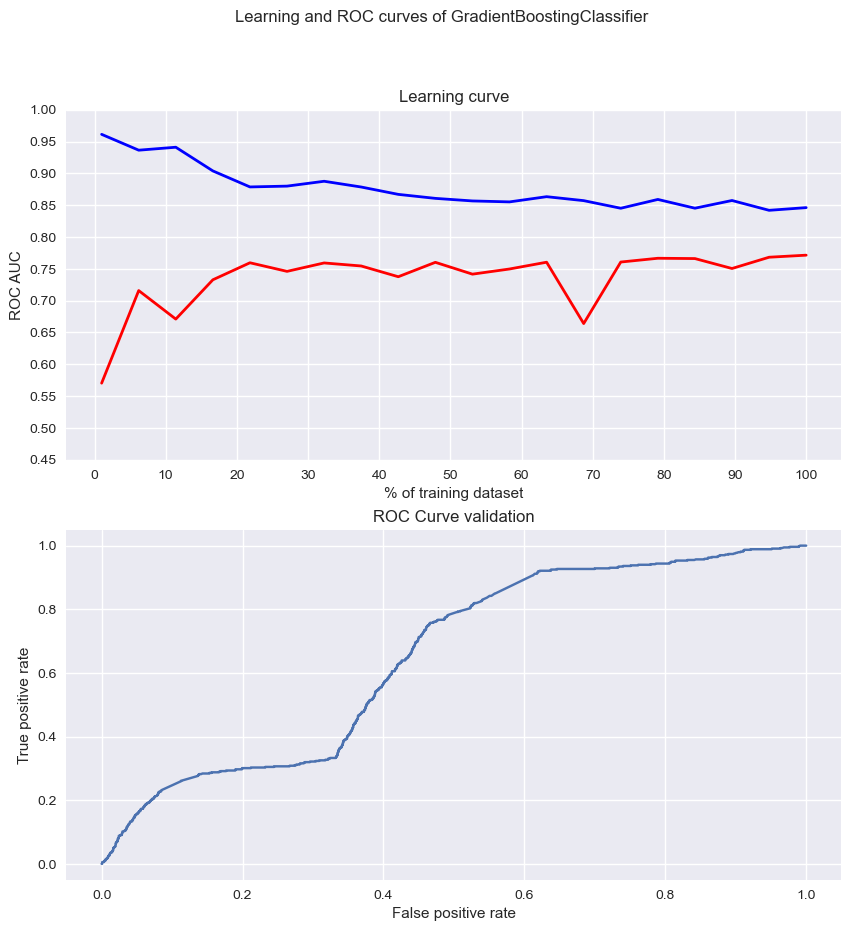

In [75]:
learning_ROC_curves(GradientBoostingClassifier(n_iter_no_change = 10), X, y)

### Fine tuning AdaBoostClassifier via GridSearchCV

In [76]:
ada = AdaBoostClassifier(algorithm = 'SAMME')
params_ada = {'learning_rate': [0.1, 0.2, 0.5, 1.0], 
              'n_estimators': [30, 100, 200], 
             }

In [77]:
ada_best = GridSearchCV(estimator = ada, 
                        param_grid = params_ada, 
                        cv = 3, 
                        scoring = 'roc_auc')
ada_best.fit(X, y)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(algorithm='SAMME'),
             param_grid={'learning_rate': [0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [30, 100, 200]},
             scoring='roc_auc')

In [78]:
print(ada_best.best_params_)
print(ada_best.best_score_)

{'learning_rate': 0.5, 'n_estimators': 200}
0.7739199098389843


### Fine tuning GradientBoostingClassifier via GridSearchCV

In [79]:
gbct = GradientBoostingClassifier(n_iter_no_change = 10)

In [80]:
params_gbct = {'learning_rate': [0.02, 0.05, 0.1, 0.2], 
               'n_estimators': [30, 100, 200], 
               'subsample': [0.5, 1.0], 
               'min_samples_split': [2, 4]
              }

In [81]:
gbct_best = GridSearchCV(estimator = gbct, 
                        param_grid = params_gbct, 
                        cv = 3, 
                        scoring = 'roc_auc')
gbct_best.fit(X, y)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(n_iter_no_change=10),
             param_grid={'learning_rate': [0.02, 0.05, 0.1, 0.2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [30, 100, 200],
                         'subsample': [0.5, 1.0]},
             scoring='roc_auc')

In [85]:
print('Best parameters: ' + str(gbct_best.best_params_))
print('Best ROC AUC score: ' + str(gbct_best.best_score_))

Best parameters: {'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Best ROC AUC score: 0.7718496085007835


In [83]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/var/folders/3c/7t4ft8dd1zq15673ckx50whh0000gn/T/ipykernel_35365/137136989.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
